# PCB Thermography Analysis Program
### Objective
This program is designed to process PCB thermography images (both radiometric `.tif` and non-radiometric `.jpg`/`.png` formats). The workflow involves:
1. Loading and displaying the thermography image.
2. Selecting and centering the PCB by defining the corners.
3. Defining an emissivity matrix for the PCB.
4. Calibrating the image based on emissivity and temperature data.

The program adapts to both `.tif` (radiometric) images and non-radiometric RGB images (`.jpg`, `.png`).

---


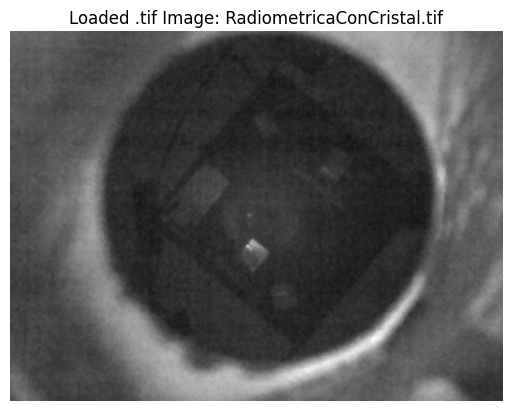

Image RadiometricaConCristal.tif loaded and displayed successfully.


In [1]:
# Import necessary modules for automatic reloading of modified modules
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
import tifffile as tiff

# Import custom image processing functions
from image_processing import load_and_display_image, select_corners_jpg, select_corners_tif
import emissivity_processing as ep
import calibration_processing as cp

# Ask the user to input the image file name (with extension)
image_name = input("Please enter the image name with extension (e.g., image.jpg or image.tif): ")

#image_name = "Thermography.tif"

#image_name = "Termografia.jpg"

# Load and display the image
image = load_and_display_image(image_name)

# Check if the image was loaded successfully
if image is not None:
    print(f"Image {image_name} loaded and displayed successfully.")
else:
    print(f"Failed to load the image {image_name}.")

In [2]:


# Direct path to the .tif file in your folder structure
tif_file_path = os.path.join("Images", image_name)

# Load the .tif image and check the min and max values
try:
    image_data = tiff.imread(tif_file_path)
    
    # Ensure the image is in 32-bit float format and print min/max values
    if image_data.dtype == np.float32:
        print("Image data type:", image_data.dtype)
        print("Min pixel value:", np.min(image_data))
        print("Max pixel value:", np.max(image_data))
    else:
        print("The image is not in 32-bit float format.")
except Exception as e:
    print("Error loading .tif file:", e)


Image data type: float32
Min pixel value: -26.364197
Max pixel value: -19.16661


## Processing the image

Temporary PNG created for corner selection with enhanced contrast.
Select 4 corners of the PCB by clicking on the image.
Corners selected: [(345, 46), (548, 210), (379, 413), (179, 244)]


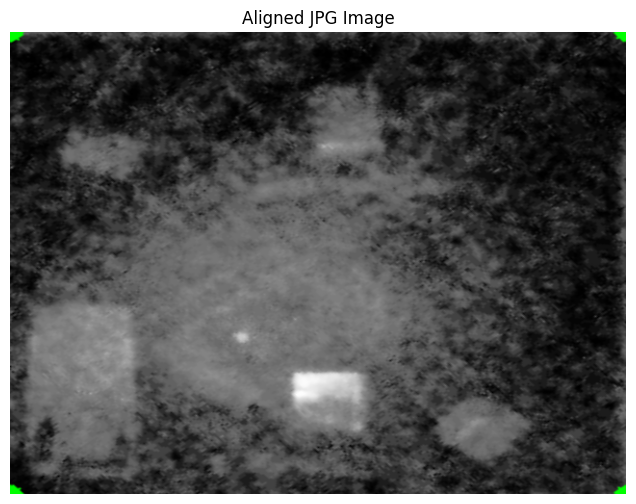

TIF image aligned and transformed.


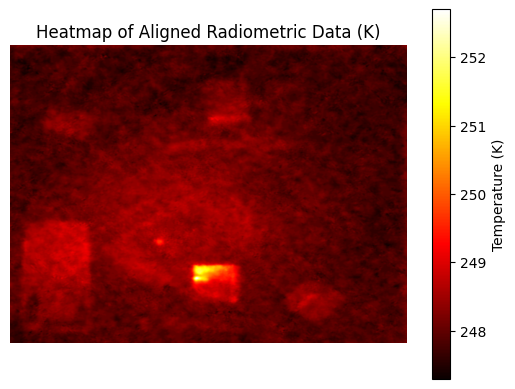

In [3]:
# Define the full image path
image_path = os.path.join("Images", image_name)

# Check the image extension (.jpg/.png or .tif)
extension = image_name.split('.')[-1].lower()

# Flag to indicate if processing a .tif file
is_tif = False

if extension in ['jpg', 'png']:
    # If the file is .jpg or .png, select corners, align the image, and calculate the RGB temperature matrix
    aligned_image_jpg, temperature_matrix_jpg, corners = select_corners_jpg(cv2.imread(image_path))
    
    # Print a portion of the RGB matrix to ensure it's not grayscale
    print("Sample of the RGB temperature matrix from the JPG image:")
    print(temperature_matrix_jpg[:5, :5, :])  # Print the first 5x5 elements of the RGB matrix

elif extension == 'tif':
    # If the file is .tif, set the flag to skip RGB processing
    is_tif = True

    # Generate a temporary .jpg for corner selection
    temp_png_path = "Images/temp_image.png"
    aligned_visual_tif, aligned_radiometric_data = select_corners_tif(image_path, cv2.imread(image_path, cv2.IMREAD_UNCHANGED), temp_png_path)

    print("TIF image aligned and transformed.")

     # Display the heatmap of the radiometric data with a proper temperature scale
    plt.imshow(aligned_radiometric_data, cmap='hot')
    plt.colorbar(label="Temperature (K)")
    plt.title("Heatmap of Aligned Radiometric Data (K)")
    plt.axis('off')
    plt.show()

else:
    # Notify the user if the file format is unsupported
    print("Unsupported file format. Only .jpg, .png, and .tif are supported.")


## Calibrating emissivity


Please click on 4 points to define the polygon.


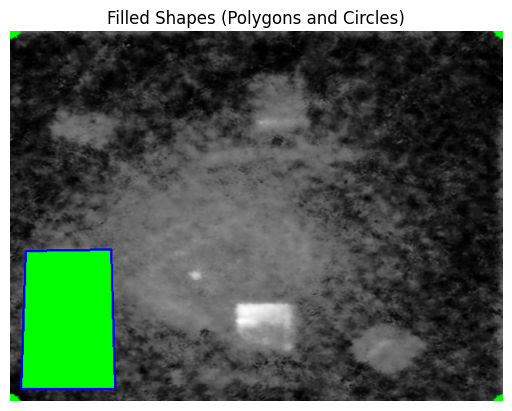

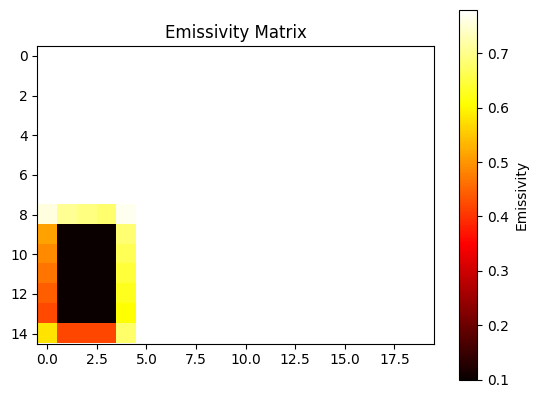


Emissivity information for defined shapes:
Polygon 1: Emissivity = 0.1


In [4]:
# Ask the user for the base emissivity value
base_emissivity = float(input("Enter the base emissivity value for the PCB: "))

# Process emissivity based on the image type
if extension in ['jpg', 'png']:
    emissivity_matrix = ep.process_emissivity(aligned_image_jpg, base_emissivity)
elif extension == 'tif':
    emissivity_matrix = ep.process_emissivity(aligned_visual_tif, base_emissivity)


## Calibrating final temperature heatmap

Radiometric data dimensions: (480, 640)
Emissivity matrix dimensions: (15, 20)
Calibrated temperature matrix (first 5x5 values):
[[317.94092 317.95886 317.99677 318.05466 318.0367 ]
 [317.8188  317.8516  317.89352 317.93292 317.94568]
 [317.7324  317.75995 317.76746 317.7869  317.7944 ]
 [317.684   317.70398 317.7039  317.68484 317.68787]
 [317.6533  317.67758 317.66483 317.63275 317.60065]]


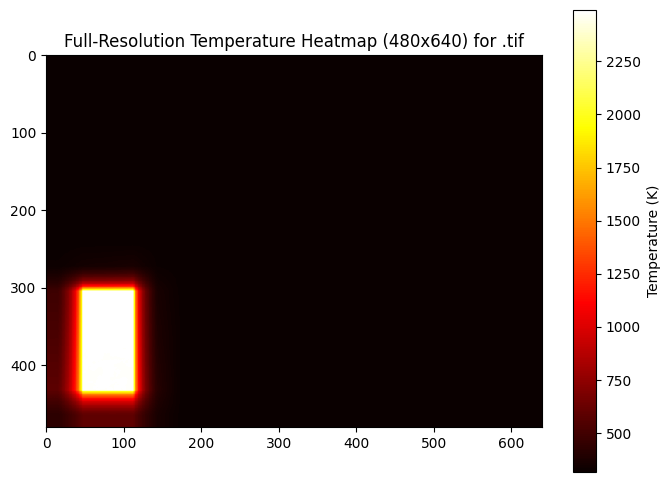

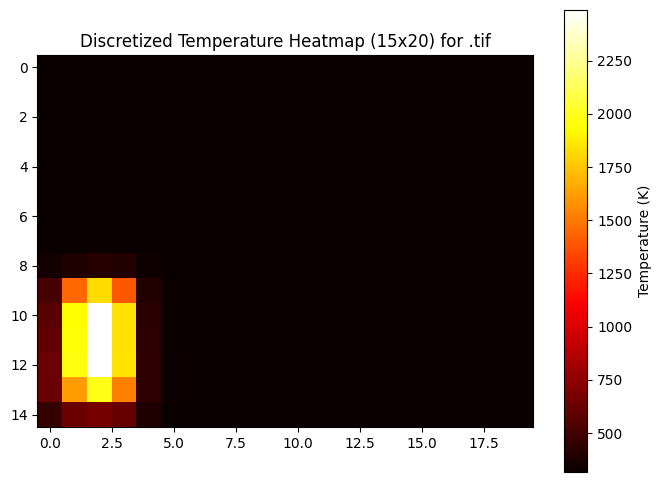

Discretized temperature matrix for .tif:
[[ 317.61676025  317.59387207  317.62988281  317.79766846  317.72119141
   317.63479614  317.60754395  317.61981201  317.73400879  317.66394043
   317.57250977  317.52575684  317.68609619  317.64263916  317.60510254
   317.7069397   317.74676514  317.64544678  317.57553101  317.63238525]
 [ 317.51712036  317.57250977  317.72164917  317.74703979  317.6177063
   317.53503418  317.67651367  317.70462036  317.69433594  317.60858154
   317.65112305  317.70568848  317.65045166  317.62423706  317.69940186
   317.61184692  317.56500244  317.64587402  317.5802002   317.4710083 ]
 [ 317.68023682  317.61236572  317.67694092  317.58505249  317.67315674
   317.81100464  317.70883179  317.61087036  317.61636353  317.78860474
   318.16339111  318.16027832  317.7902832   317.85308838  317.74789429
   317.60705566  317.61956787  317.61358643  317.58712769  317.47485352]
 [ 317.58230591  317.74493408  318.12023926  318.03570557  317.89587402
   317.75894165  317.

In [5]:
m, n = 20, 15  # Define the grid size

if extension == 'jpg':
    # Perform temperature calibration for .jpg images (initially using the RGB-based heatmap)
    calibrated_temperature_matrix = cp.calibrate_temperature('jpg', aligned_image_jpg, temperature_matrix_jpg, emissivity_matrix, m, n)
    
    # Visualize the full-scale and discretized heatmap for .jpg
    cp.visualize_temperature_matrix_jpg(calibrated_temperature_matrix)

elif extension == 'tif':
    # Perform temperature calibration for .tif images
    calibrated_temperature_matrix = cp.calibrate_temperature('tif', aligned_radiometric_data, aligned_radiometric_data, emissivity_matrix, m, n)
    
    # Visualize the .tif heatmap
    cp.visualize_temperature_matrix_tif(calibrated_temperature_matrix)


## Conclusion

In this notebook, we successfully loaded and processed thermal images in both .jpg and .tif formats. We applied corner selection, image alignment, emissivity calibration, and temperature matrix visualization. This workflow provides an efficient method to analyze thermographic data with proper calibration and visualization tools.

Next steps include refining the image processing and calibration methods to enhance accuracy and performance for various image types.


In [6]:
# Import necessary libraries and extensions
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
import tifffile as tiff

# Import custom modules
from image_processing import load_and_display_image, select_corners_jpg, select_corners_tif
import emissivity_processing as ep
import calibration_processing as cp
import radiation_correction as rc  # Newly added module for radiation correction

# Perform radiation correction
if 'aligned_radiometric_data' in locals() and aligned_radiometric_data is not None:
    print("Starting radiation correction for user-selected points...")
    radiation_data = rc.get_user_inputs(image, aligned_radiometric_data)
    print("Radiation correction completed.")

    # Print the results for the user-selected points
    for data_point in radiation_data:
        print(f"Point: {data_point['point']}, E_tot: {data_point['Etot']}, E_emit: {data_point['Eemit']}, E_ref: {data_point['Eref']}, T_ref: {data_point['Tref']}, T_fin: {data_point['Tfin']}")
else:
    print("No aligned radiometric data available for radiation correction.")




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ModuleNotFoundError: No module named 'scipy'

In [ ]:
import json

# Cargar el archivo .ipynb
with open('main_notebook.ipynb', 'r') as file:
    notebook = json.load(file)

# Extraer código de las celdas
for cell in notebook['cells']:
    if cell['cell_type'] == 'code':
        print('\n'.join(cell['source']))
